In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydae.svg_tools import svg,grid2svg
from IPython.core.display import HTML,SVG
import pydae.plot_tools as pplt
import cigre_eu_lv_acdc_tools as tools
import json
colors = pplt.set_style(plt)

In [2]:
import cigre_eu_lv_acdc_6w

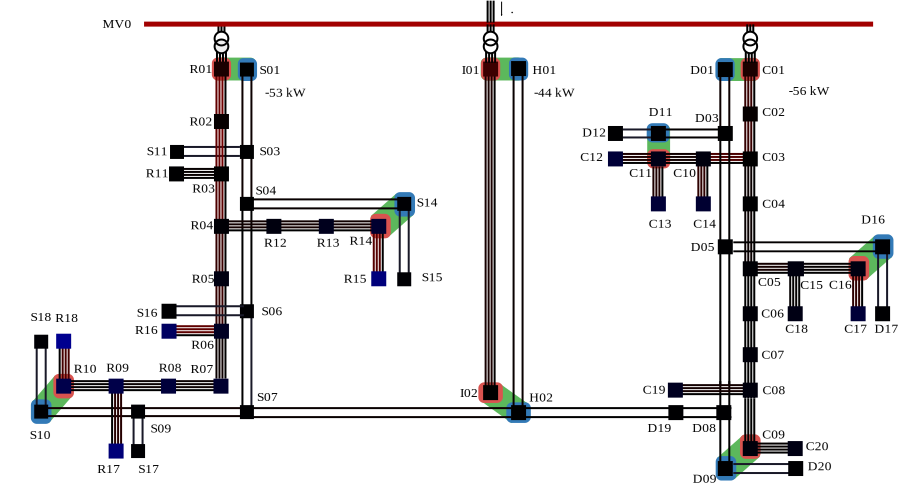

In [3]:
model = cigre_eu_lv_acdc_6w.model()
params_0 = {"K_xif":0.01,
'e_ao_m_MV0':1.04*11547.00,
'e_bo_m_MV0':1.04*11547.00,
'e_co_m_MV0':1.04*11547.00}

vscs_pq     =  [{'bus_ac':'R01','bus_dc':'S01','K_acdc':1e6},
                {'bus_ac':'R10','bus_dc':'S10','K_acdc':1e6},
                {'bus_ac':'R14','bus_dc':'S14','K_acdc':1e6},
                {'bus_ac':'I02','bus_dc':'H02','K_acdc':1e6},
                {'bus_ac':'C01','bus_dc':'D01','K_acdc':1e6},
                {'bus_ac':'C09','bus_dc':'D09','K_acdc':1e6},
                {'bus_ac':'C11','bus_dc':'D11','K_acdc':1e6},
                {'bus_ac':'C16','bus_dc':'D16','K_acdc':1e6}]

for vsc in vscs_pq:
    K_droop_id,K_droop = f"K_acdc_{vsc['bus_ac']}",vsc['K_acdc']
    params_0.update({K_droop_id:K_droop})


params = {}
params.update(params_0)

excel_file = '../../common/cigre_lv.xlsx'
load = tools.loads()
load.case = 'Case 1'
load.read(excel_file)

load.set_loads(20,params)
model.ini(params,'xy_0.json')

s = svg('./svg/cigre_eu_lv_acdc_6w.svg')
s.set_grid(model,'cigre_eu_lv_acdc_6w.hjson')
s.set_text('VSC_R01_S01_P',f"{model.get_value('p_vsc_S01')/1000:2.0f} kW")
s.set_text('VSC_I01_H01_P',f"{model.get_value('p_vsc_H01')/1000:2.0f} kW")
s.set_text('VSC_C01_D01_P',f"{model.get_value('p_vsc_D01')/1000:2.0f} kW")
# S_model = tools.get_head_power(model)
# s.set_text('MV0_P',f"{S_grid.real/1000:2.0f} kW")
# s.set_text('MV0_P',f"{S_grid.real/1000:2.0f} kW")
svg_name = 'link_case_1_2000_droops'
s.set_tooltips(f'./figs/{svg_name}.svg')    
SVG(f'./figs/{svg_name}.svg')

In [4]:
model = cigre_eu_lv_acdc_6w.model()
params = {}
params.update(params_0)
Dt_large = 60*60

times_large = np.arange(0,32*Dt_large,Dt_large)

load.set_loads(0,params)
model.ini(params,'xy_0.json')

for t in times_large:
       
    model.Dt = Dt_large/5
    model.run(t,params)

    # set loads
    load.set_loads(t/3600-3,params)   
    model.Dt = 1.0
    model.run(t+2.0,params)

    # log
    p_poi = model.get_value('p_MV0')

model.post()  

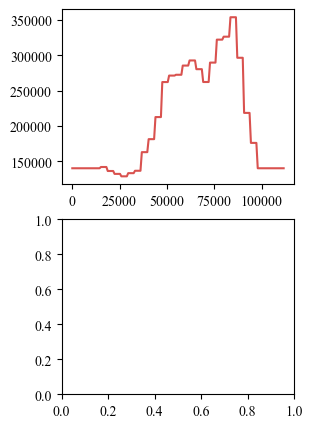

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=1,  figsize=(3,5), dpi=100)
axes[0].plot(model.Time,model.get_values('q_MV0'), color = colors[0])


In [ ]:
##### END OF FILE

In [ ]:
results = {'V_min':{},'V_max':{}}

# voltages
buses_res = [f'R{str(item).zfill(2)}' for item in range(1,19)]
buses_ind = [f'I{str(item).zfill(2)}' for item in range(1,3)]
buses_com = [f'C{str(item).zfill(2)}' for item in range(1,21)]

V_min,V_max = 1e6,-1e6
for it,bus_ac in enumerate(buses_res):
    for ph in ['a','b','c']:
        V =  gt.get_voltages(model,bus_ac,output=f'V_{ph}n_m')
        idx_min = np.argmin(V)
        idx_max = np.argmax(V)
        V_i_min = V[idx_min]
        V_i_max = V[idx_max]

        if V_i_min < V_min:
            t = model.Time[idx_min]
            results['V_min'].update({'value':V_i_min,'bus':bus_ac,'phase':ph,'t':t})
            V_min = V_i_min
        if V_i_max > V_max:
            t = model.Time[idx_max]
            results['V_max'].update({'value':V_i_max,'bus':bus_ac,'phase':ph,'t':t})
            V_max = V_i_max

# line currents
#500,150,300
results.update({'R':{'I_max':500e3/690},
                'I':{'I_max':160e3/690},
                'C':{'I_max':300e3/690},
                'I_max_pu':{}})
                
def get_currents(model,bus_j,bus_k,ph):
    i_line_r = model.get_values(f'i_t_{bus_j}_{bus_k}_2_{ph}_r') 
    i_line_i = model.get_values(f'i_t_{bus_j}_{bus_k}_2_{ph}_i') 
    i_line_m =  (i_line_r**2 + i_line_i**2)**0.5
    return i_line_m
       
I_max_pu = -1e6
for ia,area in enumerate(['R','I','C']):    
    for it,ph in enumerate([0,1,2,3]):
        I_pu = get_currents(model,'MV0',f'{area}01',ph)/results[area]['I_max']
        idx_max = np.argmax(I_pu)
        I_i_max_pu = I_pu[idx_max]
        if I_i_max_pu > I_max_pu:
            t = model.Time[idx_max]
            results['I_max_pu'].update({'value_pu':I_i_max_pu,
                                        'value':I_i_max_pu*results[area]['I_max'],
                                        'line':f'{area}01','phase':ph,'t':t})
            I_max_pu = I_i_max_pu

with open(f"cigre_eu_lv_acdc_4w2w_{load.case.replace(' ','_').lower()}.json",'w') as fobj:
    fobj.write(json.dumps(results))



In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1,  figsize=(3,5), dpi=100)

time_h = model.Time/3600*24/25 - 2.5

buses_res = [f'R{str(item).zfill(2)}' for item in range(1,19)]
buses_ind = [f'I{str(item).zfill(2)}' for item in range(1,3)]
buses_com = [f'C{str(item).zfill(2)}' for item in range(1,21)]

for it,bus_ac in enumerate(buses_res):
    V_a =  gt.get_voltages(model,bus_ac,output='V_an_m')
    axes[0].plot(time_h, np.abs(V_a)/231, label='vsc_ac', color = colors[0])

for it,bus_ac in enumerate(buses_ind):
    V_a =  gt.get_voltages(model,bus_ac,output='V_an_m')
    axes[0].plot(time_h, np.abs(V_a)/231, label='vsc_ac', color = colors[1])

for it,bus_ac in enumerate(buses_com):
    V_a =  gt.get_voltages(model,bus_ac,output='V_an_m')
    axes[0].plot(time_h, np.abs(V_a)/231, label='vsc_ac', color = colors[2])

#500,150,300
I_res_max = 500e3/690
I_ind_max = 160e3/690
I_com_max = 300e3/690
for ia,area in enumerate(['R01','I01','C01']):    
    for it,ph in enumerate([0,1,2]):
        i_l_R01_R02_r = model.get_values(f'i_t_MV0_{area}_2_{ph}_r') 
        i_l_R01_R02_i = model.get_values(f'i_t_MV0_{area}_2_{ph}_i') 
        i_l_R01_R02_m =  (i_l_R01_R02_r**2 + i_l_R01_R02_i**2)**0.5

        axes[1].plot(time_h, i_l_R01_R02_m, label='vsc_ac', color = colors[ia])
        
axes[0].plot([time_h[0], time_h[-1]], [1.05,1.05],':', color = colors[0])
axes[0].plot([time_h[0], time_h[-1]], [0.95,0.95],':', color = colors[1])
#
axes[1].plot([time_h[0],time_h[-1]], [I_res_max]*2,':', color = colors[0])
axes[1].plot([time_h[0],time_h[-1]], [I_ind_max]*2,':', color = colors[1])
axes[1].plot([time_h[0],time_h[-1]], [I_com_max]*2,':', color = colors[2])

for ax in axes:
    ax.grid()
    ax.set_xlim(0,24)
    ax.set_xticks([0,4,8,12,16,20,24])
ax.set_xlabel('Time (s)')
axes[0].set_ylabel('Voltages (pu)')
axes[1].set_ylabel('Currents (A)')

fig.savefig(f"cigre_eu_lv_acdc_4w2w_{load.case.replace(' ','_').lower()}.png")
fig.savefig(f"cigre_eu_lv_acdc_4w2w_{load.case.replace(' ','_').lower()}.svg")
fig.savefig(f"cigre_eu_lv_acdc_4w2w_{load.case.replace(' ','_').lower()}.pdf")


In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1,  figsize=(3,7), dpi=100)


for it,vsc in enumerate(vscs_end):
    if vsc['bus_ac'][0] == 'R': color = colors[0]
    if vsc['bus_ac'][0] == 'I': color = colors[1]
    if vsc['bus_ac'][0] == 'C': color = colors[2]

    vsc_ac = vsc['bus_ac']
    V_a =  model.get_values(f'V_{vsc_ac}_0_r') + 1j*model.get_values(f'V_{vsc_ac}_0_i')
    axes[0].plot(model.Time/3600, np.abs(V_a)/231, label='vsc_ac', color = color)

#500,150,300
I_res_max = 500e3/690
I_ind_max = 160e3/690
I_com_max = 300e3/690
for ia,area in enumerate(['R01','I01','C01']):    
    for it,ph in enumerate([0,1,2]):
        i_l_R01_R02_r = model.get_values(f'i_t_MV0_{area}_2_{ph}_r') 
        i_l_R01_R02_i = model.get_values(f'i_t_MV0_{area}_2_{ph}_i') 
        i_l_R01_R02_m =  (i_l_R01_R02_r**2 + i_l_R01_R02_i**2)**0.5

        axes[1].plot(model.Time/3600-2, i_l_R01_R02_m, label=vsc_ac, color = colors[ia])
        
axes[0].plot([model.Time[0]/3600-2,model.Time[-1]/3600], [1.05,1.05],':', color = colors[0])
axes[0].plot([model.Time[0]/3600-2,model.Time[-1]/3600], [0.95,0.95],':', color = colors[1])
#
axes[1].plot([model.Time[0]/3600,model.Time[-1]/3600], [I_res_max]*2,':', color = colors[0])
axes[1].plot([model.Time[0]/3600,model.Time[-1]/3600], [I_ind_max]*2,':', color = colors[1])
axes[1].plot([model.Time[0]/3600,model.Time[-1]/3600], [I_com_max]*2,':', color = colors[2])


In [ ]:
import cigre_eu_lv_acdc
import cigre_eu_lv_acdc_s
import cigre_eu_lv_acdc_tools as tools

In [ ]:
%matplotlib widget

In [ ]:


if load.case == 'Case 1':
    Dt_small = 20
    grid.Dt = Dt_small
    load.set_loads(9,params)
    grid.ini(params,'xy_0.json')
    grid.K_v_p = 5.0e3/(0.05)
    grid.sparse_trap = False
    grid.ctrl_type = '4w2w'
    grid.X_ctrl = np.load('case_1_xctrl_0.npz')['X_ctrl']
    grid.S_res,grid.S_ind,grid.S_com  = 90,100,100

%timeit grid.ini(params,'xy_0.json')

In [ ]:
grid_s = cigre_eu_lv_acdc_s.model()
%timeit grid_s.ini(params,'xy_0.json')

In [ ]:
def balancer(s_v,s_ta,s_tb,s_tc,s_va,s_vb,s_vc,Dt):
    '''
    Se equilibran las potencias de cada fase de los transformadores con el VSC de cabecera.
    p_v: potencia total a entregar por el VSC
    
    p_ta,p_tb,p_tc: potencias por fase del transformador
    p_va,p_vb,p_vc: potencias por fase, se debe cumplir que p_v = p_va + p_vb + p_vc

    '''
    T_p = 5*Dt
    
    s_lb = s_tb + s_vb
    s_ra = s_ta + s_va - s_lb
    
    s_vb_ref = (s_v-s_ra)/3 
    s_vc_ref = s_vb
    s_va_ref = s_v - 2*s_vb
    
    s_va = s_va + Dt/T_p*(s_va_ref - s_va)
    s_vb = s_vb + Dt/T_p*(s_vb_ref - s_vb)
    s_vc = s_vc + Dt/T_p*(s_vc_ref - s_vc)

    return s_va,s_vb,s_vc
    

def get_power_flows(grid,bus_from,bus_to):
    s_list = []

    v_n_r,v_n_i = grid.get_mvalue([f'V_{bus_to}_3_r',f'V_{bus_to}_3_i'])   

    for ph in [0,1,2]:
        v_r,v_i = grid.get_mvalue([f'V_{bus_to}_{ph}_r',f'V_{bus_to}_{ph}_i'])   
        i_r = grid.Z[grid.it_store-1,grid.outputs_list.index(f'i_t_{bus_from}_{bus_to}_2_{ph}_r')]
        i_i = grid.Z[grid.it_store-1,grid.outputs_list.index(f'i_t_{bus_from}_{bus_to}_2_{ph}_i')]
        s = -((v_r-v_n_r)+1j*(v_i-v_n_i))*np.conj(i_r + 1j*i_i)
        s_list += [s]
    return s_list
 
def equalizer_dc(p_v_res_dc, p_v_ind_dc, p_v_com_dc,p_v_res_ac, p_v_com_ac,S_res,S_ind,S_com,Dt):
    '''
    Siendo VSC IND grid-former se definen las referencias de potencia para VSCs RES y COM 
    de manera que los tres den una potencia en por unidad igual al bus DC.
    
    p_v_res_dc, p_v_ind_dc, p_v_com_dc: potencias totales medidas a la salida DC de cada convertidor
    p_v_res_ac, p_v_com_ac: potencia AC de referencia para los grid feeders de cabecera   
    
    
    '''
    
    T_p = 5*Dt
       
    p_dc = p_v_res_dc + p_v_ind_dc + p_v_com_dc
    
    p_v_res_ac += Dt/T_p*(p_dc*S_res/(S_res + S_ind + S_com) - p_v_res_ac) # potencias deseadas en AC
    p_v_com_ac += Dt/T_p*(p_dc*S_com/(S_res + S_ind + S_com) - p_v_com_ac) # potencias deseadas en AC
    
    return p_v_res_ac,p_v_com_ac

#get_power_flows(grid,'MV0','R01')

def get_v(grid,bus_name,phases):
    '''

    '''

    v_m_list = []
    
    ph = phases[-1]
    V_n_r_id,V_n_i_id = f"V_{bus_name}_{ph}_r",f"V_{bus_name}_{ph}_i"
    for ph in phases[:-1]:
        V_ph_r_id,V_ph_i_id = f"V_{bus_name}_{ph}_r",f"V_{bus_name}_{ph}_i"
        if V_ph_r_id in grid.y_run_list:
            v_ph_r,v_ph_i,v_n_r,v_n_i = grid.get_mvalue([V_ph_r_id,V_ph_i_id,V_n_r_id,V_n_i_id]) 
            v_m_list += [np.abs((v_ph_r-v_n_r) + 1j*(v_ph_i-v_n_i))]

    return v_m_list
    
    
def ctrl(grid):
    '''
    
    '''

    logging.basicConfig(filename='ctrl.log', encoding='utf-8', level=logging.DEBUG)

    #grid.ctrl_type = '4w2w'

        
    if grid.ctrl_type == '4w2w':
        N_ac_phases = 3
        ac_phases_list = ['a','b','c']
        
    if grid.ctrl_type == '2w2w':
        N_ac_phases = 1
        ac_phases_list = ['a']
        
        
    params = grid.params
    v_ctrl_buses = grid.v_ctrl_buses
    N_v = len(v_ctrl_buses)
    X = grid.X_ctrl
    Dt_mid = grid.Dt_mid
    grid.N_v= N_v
    p_v_res_ac, p_v_com_ac = X[0],X[1]
    
    p_vsc_a_R01,p_vsc_b_R01,p_vsc_c_R01 = X[ 2: 5]
    q_vsc_a_R01,q_vsc_b_R01,q_vsc_c_R01 = X[ 5: 8]
    p_vsc_a_I01,p_vsc_b_I01,p_vsc_c_I01 = X[ 8:11] 
    q_vsc_a_I01,q_vsc_b_I01,q_vsc_c_I01 = X[11:14]    
    p_vsc_a_C01,p_vsc_b_C01,p_vsc_c_C01 = X[14:17] 
    q_vsc_a_C01,q_vsc_b_C01,q_vsc_c_C01 = X[17:20]
    
    p_v_vsc = X[20:N_ac_phases*N_v+20] 

    S_res,S_ind,S_com = grid.S_res,grid.S_ind,grid.S_com 
    K_v_p = grid.K_v_p
    

    # V-P control of grid-feeders 
    # p = K*(v_dc_pu - v_ac_pu)
    v_min = 1e6
    
    for iv,(vsc_ac,vsc_dc,v_ref,K_i) in enumerate(v_ctrl_buses):
        
        #v_dc_m_pu = get_v(grid,vsc_dc,['a'])[0]/800
        V_0_r_id,V_1_r_id = f"V_{vsc_dc}_0_r",f"V_{vsc_dc}_1_r"
        V_0_r,V_1_r = grid.get_mvalue([V_0_r_id,V_1_r_id])
        v_dc_m_pu = (V_0_r - V_1_r)/800.0

        Vn_r_id = f"V_{vsc_ac}_{3}_r"
        Vn_i_id = f"V_{vsc_ac}_{3}_i"        
        for iph,ph in enumerate([0,1,2]):
            V_r_id = f"V_{vsc_ac}_{ph}_r"
            V_i_id = f"V_{vsc_ac}_{ph}_i"
            V_r,V_i,Vn_r,Vn_i = grid.get_mvalue([V_r_id,V_i_id,Vn_r_id,Vn_i_id])
            v_ac_m_pu = np.abs(V_r + 1j*V_i + Vn_r +1j*Vn_i)/231

            logging.debug(f'v_ctrl: v_ac_m_pu = {v_ac_m_pu:0.2f}, v_dc_m_pu = {v_dc_m_pu:0.2f}')
            epsilon = v_dc_m_pu - v_ac_m_pu
            #xi_v[iv] += Dt_mid*epsilon
            p_v_vsc[N_ac_phases*iv+iph] += Dt_mid/(5*Dt_mid)*(K_v_p*epsilon - p_v_vsc[N_ac_phases*iv+iph])
            #p_vsc = p_v_vsc[iv] + 0*p_0[iv]
            if v_ac_m_pu < v_min: v_min = v_ac_m_pu # guarda la tension mas baja del paso de integracion

            z2a = {0:'a',1:'b',2:'c',3:'n'}
            params.update({f'p_vsc_{z2a[ph]}_{vsc_ac}':p_v_vsc[N_ac_phases*iv+iph]}) # en 2w2w solo fase a

    # control de potencias totales de los grid-feeders de cabecera    
    p_v_res_dc, p_v_ind_dc, p_v_com_dc = grid.get_value('p_vsc_S01'), grid.get_value('p_vsc_H01'), grid.get_value('p_vsc_D01')
    
    p_v_res_ac, p_v_com_ac = equalizer_dc(p_v_res_dc, p_v_ind_dc, p_v_com_dc,p_v_res_ac, p_v_com_ac,S_res,S_ind,S_com,Dt_mid)        

    #p_v_R01, p_v_C01 = p_v_res_ac, p_v_com_ac


    # equilibrado de fases de los transformadores
    ## equilibrado de RES
    q_v_R01 = 0.0
    s_ta,s_tb,s_tc = get_power_flows(grid,'MV0','R01')
    p_ta,p_tb,p_tc = s_ta.real,s_tb.real,s_tc.real
    q_ta,q_tb,q_tc = s_ta.imag,s_tb.imag,s_tc.imag

    p_vsc_a_R01,p_vsc_b_R01,p_vsc_c_R01 = balancer(p_v_res_ac,p_ta,p_tb,p_tc,p_vsc_a_R01,p_vsc_b_R01,p_vsc_c_R01,Dt_mid)
    q_vsc_a_R01,q_vsc_b_R01,q_vsc_c_R01 = balancer(   q_v_R01,q_ta,q_tb,q_tc,q_vsc_a_R01,q_vsc_b_R01,q_vsc_c_R01,Dt_mid)

    ## equilibrado de IND
    p_vsc_H01 = grid.get_value('p_vsc_H01')
    q_v_I01 = 0.0
    s_ta,s_tb,s_tc = get_power_flows(grid,'MV0','I01')
    p_ta,p_tb,p_tc = s_ta.real,s_tb.real,s_tc.real
    q_ta,q_tb,q_tc = s_ta.imag,s_tb.imag,s_tc.imag

    logging.debug(f'IND: p_ta = {p_ta:0.2f}, p_tb = {p_tb:0.2f}, p_tc = {p_tc:0.2f}')
    logging.debug(f'IND: q_ta = {q_ta:0.2f}, q_tb = {q_tb:0.2f}, q_tc = {q_tc:0.2f}')

    p_vsc_a_I01,p_vsc_b_I01,p_vsc_c_I01 = balancer(p_vsc_H01,p_ta,p_tb,p_tc,p_vsc_a_I01,p_vsc_b_I01,p_vsc_c_I01,Dt_mid)
    q_vsc_a_I01,q_vsc_b_I01,q_vsc_c_I01 = balancer(q_v_I01,q_ta,q_tb,q_tc,q_vsc_a_I01,q_vsc_b_I01,q_vsc_c_I01,Dt_mid)

    if np.abs(p_vsc_H01) > 1.0:
        C_a_I01 = p_vsc_a_I01/p_vsc_H01
        C_b_I01 = p_vsc_b_I01/p_vsc_H01
        C_c_I01 = p_vsc_c_I01/p_vsc_H01
    else: C_a_I01,C_b_I01,C_c_I01 = 0,0,0

    logging.debug(f'IND: p_vsc_a_I01 = {p_vsc_a_I01:0.2f}, p_vsc_b_I01 = {p_vsc_b_I01:0.2f}, p_vsc_c_I01 = {p_vsc_c_I01:0.2f}')



    ## equilibrado de COM  
    q_v_C01 = 0.0
    s_ta,s_tb,s_tc = get_power_flows(grid,'MV0','C01')
    p_ta,p_tb,p_tc = s_ta.real,s_tb.real,s_tc.real
    q_ta,q_tb,q_tc = s_ta.imag,s_tb.imag,s_tc.imag

    p_vsc_a_C01,p_vsc_b_C01,p_vsc_c_C01 = balancer(p_v_com_ac,p_ta,p_tb,p_tc,p_vsc_a_C01,p_vsc_b_C01,p_vsc_c_C01,Dt_mid)
    q_vsc_a_C01,q_vsc_b_C01,q_vsc_c_C01 = balancer(q_v_C01,q_ta,q_tb,q_tc,q_vsc_a_C01,q_vsc_b_C01,q_vsc_c_C01,Dt_mid)


    # se actualizan los parámetros para el equilibrado
    params.update({f'p_vsc_a_R01':p_vsc_a_R01,f'p_vsc_b_R01':p_vsc_b_R01,f'p_vsc_c_R01':p_vsc_c_R01})
    params.update({f'q_vsc_a_R01':q_vsc_a_R01,f'q_vsc_b_R01':q_vsc_b_R01,f'q_vsc_c_R01':q_vsc_c_R01})
    params.update({f'p_vsc_a_C01':p_vsc_a_C01,f'p_vsc_b_C01':p_vsc_b_C01,f'p_vsc_c_C01':p_vsc_c_C01})
    params.update({f'q_vsc_a_C01':q_vsc_a_C01,f'q_vsc_b_C01':q_vsc_b_C01,f'q_vsc_c_C01':q_vsc_c_C01})
    params.update({f'q_vsc_a_I01':q_vsc_a_I01,f'q_vsc_b_I01':q_vsc_b_I01,f'q_vsc_c_I01':q_vsc_c_I01})

    params.update({'C_a_I01':C_a_I01,'C_b_I01':C_b_I01,'C_c_I01':C_c_I01})

    
    grid.p_v_res_ac = p_v_res_ac
    grid.p_v_com_ac = p_v_com_ac
    grid.v_min = v_min

    X[0],X[1] = p_v_res_ac, p_v_com_ac 
    
    X[ 2: 5] = p_vsc_a_R01,p_vsc_b_R01,p_vsc_c_R01
    X[ 5: 8] = q_vsc_a_R01,q_vsc_b_R01,q_vsc_c_R01
    X[ 8:11] = p_vsc_a_I01,p_vsc_b_I01,p_vsc_c_I01
    X[11:14] = q_vsc_a_I01,q_vsc_b_I01,q_vsc_c_I01  
    X[14:17] = p_vsc_a_C01,p_vsc_b_C01,p_vsc_c_C01
    X[17:20] = q_vsc_a_C01,q_vsc_b_C01,q_vsc_c_C01
    
    X[20:N_ac_phases*N_v+20] = p_v_vsc



In [ ]:
params = {"K_xif":0.01,
'e_ao_m_MV0':1.02*11547.00,
'e_bo_m_MV0':1.02*11547.00,
'e_co_m_MV0':1.02*11547.00}

excel_file = '../cigre_lv.xlsx'
load = tools.loads()
load.case = 'Case 2'
load.read(excel_file)

params_case_1 = {}
params_case_2 = {}
params_case_3 = {}

if load.case == 'Case 1': params.update(params_case_1)
if load.case == 'Case 2': params.update(params_case_2)
if load.case == 'Case 3': params.update(params_case_3)


grid = cigre_eu_lv_acdc.model()
grid.max_it = 50


if load.case == 'Case 1':
    Dt_small = 20
    grid.Dt = Dt_small
    load.set_loads(9,params)
    grid.ini(params,'xy_0.json')
    grid.K_v_p = 5.0e3/(0.05)
    grid.sparse_trap = False
    grid.ctrl_type = '4w2w'
    grid.X_ctrl = np.load('case_1_xctrl_0.npz')['X_ctrl']
    grid.S_res,grid.S_ind,grid.S_com  = 90,100,100
    
if load.case == 'Case 2':
    Dt_small = 20
    grid.Dt = Dt_small
    load.set_loads(0,params)
    grid.ini(params,'xy_0.json')
    grid.K_v_p = 30e3/(0.05)
    grid.sparse_trap = False
    grid.ctrl_type = '4w2w'
    grid.X_ctrl = np.load('case_2_xctrl_0.npz')['X_ctrl']
    grid.S_res,grid.S_ind,grid.S_com  = 100,80,100

if load.case == 'Case 3':
    Dt_small = 20
    grid.Dt = Dt_small
    load.set_loads(4,params)
    grid.ini(params,'xy_0_case3.json')
    grid.K_v_p = 10.0e3/(0.05)
    grid.sparse_trap = False
    grid.ctrl_type = '2w2w'
    grid.X_ctrl = np.load('case_3_xctrl_0.npz')['X_ctrl']*0
    grid.S_res,grid.S_ind,grid.S_com  = 100,80,100
    
#grid.save_xy_0('xy_0_case3.json')
#np.savez('case_3_xctrl_0',X_ctrl=grid.X_ctrl)

if grid.sparse_trap:
    grid.eval_preconditioner_trap()
    

Dt_mid = 2*Dt_small
Dt_large = 1*60*60

grid.Dt = Dt_small
grid.Dt_mid = Dt_mid

times_mid = np.arange(0,Dt_mid*30,Dt_mid)
times_large = np.arange(0,28*60*60,Dt_large)

v_ctrl_buses = [('R10','S10',233,5e3),('R14','S14',231,5e3),
                ('I02','H02',231,3e3),
                ('C09','D09',231,1e3),('C11','D11',231,1e3),('C16','D16',231,1e3)]


grid.v_ctrl_buses = v_ctrl_buses

grid.params = params

for t_large in times_large:
       
    # set loads
    t = t_large
    
    #load.set_loads(t/3600,params)
    if t<(3*3600):
        load.set_loads(0/3600,params)
    else:
        load.set_loads(t/3600-3,params)        
            
    grid.Dt = Dt_small

    #grid.eval_preconditioner_trap()
    
    for t_mid in times_mid:
        t = t_mid + t_large
        
        ctrl(grid)
    
        # run   
        if grid.sparse_trap:
            grid.sprun(t,params)
        else:
            grid.run(t,params)

        str_out = f"t = {time.strftime('%H:%M:%S', time.gmtime(t))}, "
        str_out += f'p_v_res_ac = {grid.p_v_res_ac/1e3:5.1f}, p_v_com_ac = {grid.p_v_com_ac/1e3:5.1f}, v_min = {grid.v_min:3.2f}'
        # sys.stdout.write("\r" + str_out  )
        # sys.stdout.flush()
                    
        logging.debug(f'{str_out}')
    
    #        #print(coef_a_R01,i_t_MV0_R01_2_a_m,i_t_MV0_R01_2_b_m,Dp)
    grid.Dt = Dt_large/5
    t = t_large + Dt_large
    #grid.eval_preconditioner_trap()
    grid.run(t,params)
    #if not grid.sparse_trap:
    #    grid.sparse_trap == True
    #grid.Dt = Dt_small
    #grid.eval_preconditioner_trap()
    #grid.sparse_trap = True
grid.post()  

In [ ]:
grid.post()  

In [ ]:
#params = {'v_MV0_a_r':1.025* 11547.00,'v_MV0_a_i':1.025*0.00,
#'v_MV0_b_r':1.025* -5773.50,'v_MV0_b_i':1.025*-10000.00,
#'v_MV0_c_r':1.025* -5773.50,'v_MV0_c_i':1.025* 10000.00,
# 'C_a_I01': 1/3, 'C_b_I01':  1/3, 'C_c_I01':  1/3}
#
#grid = cigre_eu_lv_acdc.model()
#grid.max_it = 50
#excel_file = '../cigre_lv.xlsx'
#load = tools.loads()
#load.case = 'Case 1'
#load.read(excel_file)
#load.set_loads(0,params)
##grid.ini(params,'xy_0_case1.json')
##grid.save_xy_0('xy_0_case1.json')

In [ ]:
grid.X_ctrl

In [ ]:
grid.post()    

In [ ]:
s = svg('cigre_eu_lv_acdc_v2.svg')
s.set_grid(grid,'cigre_eu_lv_acdc.json')
s.set_text('VSC_R01_S01_P',f"{grid.get_value('p_vsc_S01')/1000:2.0f} kW")
s.set_text('VSC_I01_H01_P',f"{grid.get_value('p_vsc_H01')/1000:2.0f} kW")
s.set_text('VSC_C01_D01_P',f"{grid.get_value('p_vsc_D01')/1000:2.0f} kW")
S_grid = tools.get_head_power(grid)
s.set_text('MV0_P',f"{S_grid.real/1000:2.0f} kW")
s.set_tooltips(f'case_{case}.svg')    

print(case)
SVG(f'case_{case}.svg')

In [ ]:
s = svg('./figs/cigre_eu_lv_acdc_4w2w.svg')
s.set_grid(grid,'cigre_eu_lv_acdc.json')
s.set_text('VSC_R01_S01_P',f"{grid.get_value('p_vsc_S01')/1000:2.0f} kW")
s.set_text('VSC_I01_H01_P',f"{grid.get_value('p_vsc_H01')/1000:2.0f} kW")
s.set_text('VSC_C01_D01_P',f"{grid.get_value('p_vsc_D01')/1000:2.0f} kW")
# S_grid = tools.get_head_power(grid)
# s.set_text('MV0_P',f"{S_grid.real/1000:5.1f} kW")
s.set_tooltips('case_2_opt.svg')    
SVG('case_2_opt.svg')

In [ ]:
grid.report_u()

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1,  dpi=100)


for iv,(vsc_ac,vsc_dc,v_ref,K_i) in enumerate(v_ctrl_buses):
    if vsc_ac[0] == 'R': color = colors[0]
    if vsc_ac[0] == 'I': color = colors[1]
    if vsc_ac[0] == 'C': color = colors[2]

    V_a =  grid.get_values(f'V_{vsc_ac}_0_r') + 1j*grid.get_values(f'V_{vsc_ac}_0_i')
    axes[0].plot(grid.Time/3600-2, np.abs(V_a)/231, label=vsc_ac, color = color)

#500,150,300
I_res_max = 500e3/690
I_ind_max = 160e3/690
I_com_max = 300e3/690
for ia,area in enumerate(['R01','I01','C01']):    
    for it,ph in enumerate([0,1,2]):
        i_l_R01_R02_r = grid.get_values(f'i_t_MV0_{area}_2_{ph}_r') 
        i_l_R01_R02_i = grid.get_values(f'i_t_MV0_{area}_2_{ph}_i') 
        i_l_R01_R02_m =  (i_l_R01_R02_r**2 + i_l_R01_R02_i**2)**0.5

        axes[1].plot(grid.Time/3600-2, i_l_R01_R02_m, label=vsc_ac, color = colors[ia])
        
axes[0].plot([grid.Time[0]/3600-2,grid.Time[-1]/3600], [1.05,1.05],':', color = colors[0])
axes[0].plot([grid.Time[0]/3600-2,grid.Time[-1]/3600], [0.95,0.95],':', color = colors[1])
#
axes[1].plot([grid.Time[0]/3600,grid.Time[-1]/3600], [I_res_max]*2,':', color = colors[0])
axes[1].plot([grid.Time[0]/3600,grid.Time[-1]/3600], [I_ind_max]*2,':', color = colors[1])
axes[1].plot([grid.Time[0]/3600,grid.Time[-1]/3600], [I_com_max]*2,':', color = colors[2])

#axes[1].plot(grid.Time, grid.get_values(f'p_total')/1e3, label=bus, color = color)


#axes.grid()
#axes.set_ylabel('Transformers powers (kVA)')
#axes.set_xlabel('Time (h)')
#axes[0].set_xlim([0,24])
#axes[1].set_xlim([0,24])

#axes.legend()
#axes.legend()
#fig.tight_layout()
#fig.savefig('case_2_opt_trafos.pdf')

In [ ]:
def save_run(self,file_name):
    np.savez(file_name,
         X=self.X,Y=self.Y,Z=self.Z,
         x_list = self.x_list,
         y_ini_list = self.y_ini_list,
         y_run_list = self.y_run_list,
         u_ini_list=self.u_ini_list,
         u_run_list=self.u_run_list,  
         z_list=self.outputs_list, 
        )
    
    

In [ ]:
save_run(grid,'cigre2')

In [ ]:
grid.report_z()

In [ ]:
class opt_class:
    
    def __init__(self,grid):
        self.grid = grid    
        self.x_0 = []      
        self.bounds = []
        self.obj = ''
        self.cons_var_1 = ''
        
        self.t = 0.0       
        self.obj_evals = 0
        self.compute_jac = False
        self.method = 'SLSQP'
        self.grid.I_res_t_max = 720.0*1.5
        self.grid.I_ind_t_max = 210.0*1.5
        self.grid.I_com_t_max = 430.0*1.5
        
    def set_inputs(self,inputs):

        self.x_0 = [item['ini'] for item in  inputs ]
        self.bounds = [(item['min'],item['max']) for item in  inputs]
        self.inputs_id = [item['id'] for item in inputs]
        
        inputs_run_list = self.grid.inputs_run_list
        
        #self.idx_u = [inputs_run_list.index(item['id']) for item in inputs]

        params = self.grid.params
        
        u = self.x_0
        
        self.update_inputs(u)
        self.grid.ini(params)

    def update_inputs(self,u):

        it = 0
        new_params = {}
        for u_id in self.inputs_id:

            if u_id == 'coef_a_R01':
                coef_a_R01 = u[it]
                coef_b_R01 = (1-coef_a_R01)/2
                coef_c_R01 = (1-coef_a_R01)/2
                new_params.update({'coef_a_R01':coef_a_R01})
                new_params.update({'coef_b_R01':coef_b_R01})
                new_params.update({'coef_c_R01':coef_c_R01})
                continue
            if u_id == 'C_a_I01':
                coef_a_I01 = u[it]
                coef_b_I01 = (1-coef_a_I01)/2
                coef_c_I01 = (1-coef_a_I01)/2
                new_params.update({'C_a_I01':coef_a_I01})
                new_params.update({'C_b_I01':coef_b_I01})
                new_params.update({'C_c_I01':coef_c_I01})  
                continue
            if u_id == 'coef_a_C01':
                coef_a_C01 = u[it]
                coef_b_C01 = (1-coef_a_C01)/2
                coef_c_C01 = (1-coef_a_C01)/2
                new_params.update({'coef_a_C01':coef_a_C01})
                new_params.update({'coef_b_C01':coef_b_C01})
                new_params.update({'coef_c_C01':coef_c_C01})  
                continue
            
            new_params.update({u_id:u[it]})
            
            it+=1
            
        self.new_params = new_params    
        print(new_params)
        self.grid.params.update(new_params)

            
        #self.idx_z = grid.outputs_list.index('p_t_AC1_AC2_1')

        
        
    def optimize(self):
            
        #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
        cons_1 = {'type':'ineq','fun':self.cons_res}
        cons_2 = {'type':'ineq','fun':self.cons_ind}
        cons_3 = {'type':'ineq','fun':self.cons_com}
        
        #nlc = NonlinearConstraint(self.cons_1, -30, 30)

        
        cons = [cons_1,cons_2,cons_3]

        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        if self.compute_jac:
            res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, jac=self.jac_eval, constraints=cons)  #
        else:
            res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, constraints=cons)  #
        #SLSQP, Powell,trust-constr
        
        self.res = res
        self.x_0 = res.x 
        return res.x
    
    def jac_eval(self,u):
        self.grid.eval_jac_u2z()
        self.idx_z = self.grid.outputs_list.index(self.obj)
               
        return self.grid.jac_u2z[self.idx_z,self.idx_u].toarray()
        
 
    def obj_eval(self,u):
        
        self.obj_evals +=1
        
        
        
        #print(new_params)
        self.update_inputs(u)
        params = self.grid.params
        
        self.grid.ini(params)
        p_total = self.grid.get_value(self.obj)
        
        buses_v = ['R10','R14','C09','C11','C16']
        error2_v = 0
        for item in buses_v:
            v_a_r,v_a_i,v_n_r,v_n_i = self.grid.get_mvalue([f'v_{item}_a_r',f'v_{item}_a_i',f'v_{item}_n_r',f'v_{item}_n_i']) 
            v_m = np.abs((v_a_r-v_n_r) + 1j*(v_a_i-v_n_i))
            error2_v += 1e5*(231-v_m)**2

        obj_value = p_total + error2_v
           
        str_out = f"t = {self.t/3600:3.1f}, Total grid power = {p_total/1000:7.2f} kW, V_r = {error2_v:3.0g}, "
        str_out+= f"Trafo RES: {self.grid.get_value('i_res'):4.0f} A, "
        str_out+= f"Trafo IND: {self.grid.get_value('i_ind'):4.0f} A, "
        str_out+= f"Trafo COM: {self.grid.get_value('i_com'):4.0f} A, "
        str_out+= f" Obj evals = {self.obj_evals} "
        sys.stdout.write("\r" + str_out  )
        sys.stdout.flush()

        return obj_value
    
    def cons_res(self,u):
 
        self.update_inputs(u)

        self.grid.ini(self.grid.params)
        
        i_res_max = 0.0
        for ph in ['a','b','c']:
            
            i_r,i_i = self.grid.get_mvalue([f'i_t_MV0_R01_2_{ph}_r',f'i_t_MV0_R01_2_{ph}_i'])
            i_m = np.abs(i_r+1j*i_i)
            if i_m > i_res_max: i_res_max = i_m


        
        return self.grid.I_res_t_max - i_res_max 

    def cons_ind(self,u):
 
        self.update_inputs(u)

        
        self.grid.ini(self.grid.params)
        
        return self.grid.I_ind_t_max - self.grid.get_value('i_ind') 
    
    def cons_com(self,u):

        self.update_inputs(u)

        
        self.grid.spini(self.grid.params)
        
        return self.grid.I_com_t_max - self.grid.get_value('i_com') 

In [ ]:
inputs = [{'id':'p_vsc_R01','min':-200e3,'max':-10e3,'ini':-20e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_C01','min':-200e3,'max':-10e3,'ini':-20e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_R10','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_R14','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_I02','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_C09','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_C11','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'p_vsc_C16','min': -10e3,'max': 70e3,'ini': 10e3, 'ph_sharing':[1/3,1/3,1/3]},
          {'id':'coef_a_R01','min': 0.1,'max': 0.4,'ini': 0.2},
          {'id':   'C_a_I01','min': 0.1,'max': 0.4,'ini': 0.2},
          {'id':'coef_a_C01','min': 0.1,'max': 0.4,'ini': 0.2}]


h = 24

grid_1 = cigre_eu_lv_acdc.model()

params = {'v_MV0_a_r':1.025* 11547.00,
'v_MV0_a_i':1.025*     0.00,
'v_MV0_b_r':1.025* -5773.50,
'v_MV0_b_i':1.025*-10000.00,
'v_MV0_c_r':1.025* -5773.50,
'v_MV0_c_i':1.025* 10000.00}



excel_file = '../cigre_lv.xlsx'
load = tools.loads()
load.case = 'Case 3'
load.read(excel_file)
load.set_loads(20,params)

params_case_1 = {'p_vsc_R01':-80e3, 'p_vsc_C01':-80e3, 
                 'p_vsc_R10':90e3, 'coef_a_R10':1/3,'coef_b_R10':1/3,'coef_c_R10':1/3,
                 'p_vsc_R14':60e3, 'coef_a_R14':1/3,'coef_b_R14':1/3,'coef_c_R14':1/3,
                 'p_vsc_C09':10e3, 'coef_a_C09':1/3,'coef_b_C09':1/3,'coef_c_C09':1/3,
                 'p_vsc_C11':40e3, 'coef_a_C11':1/3,'coef_b_C11':1/3,'coef_c_C11':1/3,
                 'p_vsc_C16':50e3, 'coef_a_C16':1/3,'coef_b_C16':1/3,'coef_c_C16':1/3,}

params_case_2 = {'p_vsc_R01':-100e3, 'p_vsc_C01':-100e3, 
                 'p_vsc_R10':50e3, 'coef_a_R10':1/3,'coef_b_R10':1/3,'coef_c_R10':1/3,
                 'p_vsc_R14':20e3, 'coef_a_R14':1/3,'coef_b_R14':1/3,'coef_c_R14':1/3,
                 'p_vsc_C09':10e3, 'coef_a_C09':1/3,'coef_b_C09':1/3,'coef_c_C09':1/3,
                 'p_vsc_C11':20e3, 'coef_a_C11':1/3,'coef_b_C11':1/3,'coef_c_C11':1/3,
                 'p_vsc_C16':10e3, 'coef_a_C16':1/3,'coef_b_C16':1/3,'coef_c_C16':1/3,}

params_case_3 = {'p_vsc_R01':-150e3, 'coef_a_R01':0.2,'coef_b_R01':0.4,'coef_c_R01':0.4,
                 'p_vsc_C01':-150e3, 'coef_a_C01':0.2,'coef_b_C01':0.4,'coef_c_C01':0.4,
                 'p_vsc_R10':  50e3, 'coef_a_R10':1,'coef_b_R10':0.0,'coef_c_R10':0.0,
                 'p_vsc_R14':  20e3, 'coef_a_R14':1,'coef_b_R14':0.0,'coef_c_R14':0.0,
                 'p_vsc_I02':  20e3, 'coef_a_I02':1,'coef_b_I02':0.0,'coef_c_I02':0.0,
                 'p_vsc_C09':  10e3, 'coef_a_C09':1,'coef_b_C09':0.0,'coef_c_C09':0.0,
                 'p_vsc_C11':  20e3, 'coef_a_C11':1,'coef_b_C11':0.0,'coef_c_C11':0.0,
                 'p_vsc_C16':  10e3, 'coef_a_C16':1,'coef_b_C16':0.0,'coef_c_C16':0.0,}

if load.case == 'Case 1': params.update(params_case_1)
if load.case == 'Case 2': params.update(params_case_2)
if load.case == 'Case 3': params.update(params_case_3)
    
grid_1.ini(params,'xy_0_case2.json')
grid_1.eval_preconditioner_ini()
#grid_1.spini(params)

grid_1.params = params
opt = opt_class(grid_1)

opt.set_inputs(inputs)


In [ ]:
#opt.grid.eval_preconditioner_ini()

opt.method = 'SLSQP'  #SLSQP, Powell,trust-constr,TNC  
                    #Constraints definition (only for COBYLA, SLSQP and trust-constr).


opt.compute_jac = False
opt.obj = 'p_total'
#opt.cons_var_1 = 'i_l_DC2_DC4_a_r'
opt.grid.params = params
opt.optimize()


In [ ]:
grid.report_z()

In [ ]:
grid = opt.grid
s = svg('./figs/cigre_eu_lv_acdc_2w2w.svg')
s.set_grid(grid,'cigre_eu_lv_acdc.json')
s.set_text('VSC_R01_S01_P',f"{grid.get_value('p_vsc_S01')/1000:2.0f} kW")
s.set_text('VSC_I01_H01_P',f"{grid.get_value('p_vsc_H01')/1000:2.0f} kW")
s.set_text('VSC_C01_D01_P',f"{grid.get_value('p_vsc_D01')/1000:2.0f} kW")
S_grid = tools.get_head_power(grid)
s.set_text('MV0_P',f"{S_grid.real/1000:5.1f} kW")
s.set_tooltips('case_2_opt.svg')    
SVG('case_2_opt.svg')

In [ ]:
p_res,q_res = grid.get_mvalue(['p_t_MV0_R01_1','q_t_MV0_R01_1'])
p_ind,q_ind = grid.get_mvalue(['p_t_MV0_I01_1','q_t_MV0_I01_1'])
p_com,q_com = grid.get_mvalue(['p_t_MV0_C01_1','q_t_MV0_C01_1'])

s_res = p_res +1j*q_res
s_ind = p_ind +1j*q_ind
s_com = p_com +1j*q_com

print(f's_res = {p_res/1e3:0.1f} + j{q_res/1e3:5.1f}, {np.abs(s_res)/1e3:5.1f} kVA, {np.abs(s_res)/690:5.1f} A')
print(f's_ind = {p_ind/1e3:0.1f} + j{q_ind/1e3:5.1f}, {np.abs(s_ind)/1e3:5.1f} kVA, {np.abs(s_ind)/690:5.1f} A')
print(f's_com = {p_com/1e3:0.1f} + j{q_com/1e3:5.1f}, {np.abs(s_com)/1e3:5.1f} kVA, {np.abs(s_com)/690:5.1f} A')


In [ ]:
grid.report_z()

In [ ]:
# Parameters
params = {'p_vsc_C01':10e3}
update_loads(0,params)

# Optimization grid
inputs = [{'id':'p_vsc_R01','min':-100e3,'max':-10e3,'ini':-20e3},
          {'id':'p_vsc_C01','min':-100e3,'max':-10e3,'ini':-20e3},
          {'id':'p_vsc_R10','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_R14','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_I02','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C09','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C11','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C16','min':-10e3,'max':70e3,'ini':10e3}]

grid_opt = cigre_eu_lv_acdc_opt.cigre_eu_lv_acdc_opt_class()
opt = opt_class(grid_opt)
opt.grid.params = params
opt.x_0 = np.array([-25814.81972819, -27441.69458212,  30552.64726183,  23360.88463946,
         5859.92208006,   1003.40947217,   7751.23200544,   5684.00246266])
opt.grid.ini(params,'xy_0_case2.json')
opt.grid.eval_preconditioner_ini()

opt.set_inputs(inputs)

opt.grid.eval_preconditioner_ini()
opt.method = 'SLSQP'  #SLSQP, Powell,trust-constr,TNC  
opt.compute_jac = True
opt.obj = 'p_total'

# Actual grid
grid = cigre_eu_lv_acdc_opt.cigre_eu_lv_acdc_opt_class()
grid.Dt = 60*60
grid.decimation = 1
grid.params = params

grid.ini(params,'xy_0_case2.json')
grid.eval_preconditioner_trap()

times = np.arange(0,26,1)*60*60

update_loads(h,opt.grid.params)
opt.t = t
opt.optimize()
grid.ini(opt.grid.params)    
    
#times = [20*60*60]
t_0 = time.time()
it_p = 0
for t in times:
    h = t/3600
    update_loads(h,opt.grid.params)
    opt.t = t
    opt.optimize()
    
    grid.run(t,opt.grid.params)

    it_p += 1
grid.post();
print('End')

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1,  dpi=100)


axes.plot([0,25], [500]*2,':',color=colors[0])
axes.plot([0,25], [150]*2,':',color=colors[1])
axes.plot([0,25], [300]*2,':',color=colors[2])

axes.plot(grid.Time/3600, 690*grid.get_values('i_res')/1e3, label='RES')
axes.plot(grid.Time/3600, 690*grid.get_values('i_ind')/1e3, label='IND')
axes.plot(grid.Time/3600, 690*grid.get_values('i_com')/1e3, label='COM')

axes.grid()
axes.set_ylabel('Transformers powers (kVA)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])
axes.legend()
axes.legend()
fig.tight_layout()
fig.savefig('case_2_opt_trafos.pdf')

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(3.3, 4.0), gridspec_kw={'height_ratios': [1, 1]},dpi=100)

inputs = [{'id':'p_vsc_R01','min':-100e3,'max':-10e3,'ini':-20e3},
          {'id':'p_vsc_C01','min':-100e3,'max':-10e3,'ini':-20e3},
          {'id':'p_vsc_R10','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_R14','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_I02','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C09','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C11','min':-10e3,'max':70e3,'ini':10e3},
          {'id':'p_vsc_C16','min':-10e3,'max':70e3,'ini':10e3}]

axes[0].plot(grid.Time/3600, grid.get_values('p_vsc_R01')/1e3, label='RES')
axes[0].plot(grid.Time/3600, grid.get_values('p_vsc_I01')/1e3, label='IND')
axes[0].plot(grid.Time/3600, grid.get_values('p_vsc_C01')/1e3, label='COM')

axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_R10')/1e3, label='R10-S10', color=colors[0])
axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_R14')/1e3,':', label='R14-S14', color=colors[0])
axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_I02')/1e3, label='I02-H02', color=colors[1])
axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_C09')/1e3, label='C09-D09', color=colors[2])
axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_C11')/1e3,':', label='C11-D11', color=colors[2])
axes[1].plot(grid.Time/3600, grid.get_values('p_vsc_C16')/1e3,'--', label='C16-D16', color=colors[2])


axes[0].grid()
axes[0].set_ylabel('Head VSCs powers (kW)')
axes[0].set_xlabel('Time (h)')
axes[0].set_xlim([0,24])
axes[0].legend()
axes[1].legend()
axes[1].set_xlim([0,24])
axes[1].grid()

fig.tight_layout()
fig.savefig('case_2_vsc_powers.pdf')

In [ ]:
grid.report_z()

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)

i_t_MV0_R01_1_a_r = grid.get_values('i_t_MV0_R01_1_a_r')
i_t_MV0_R01_1_a_i = grid.get_values('i_t_MV0_R01_1_a_i')
S_res = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_R01_1_a_r+1j*i_t_MV0_R01_1_a_i)
i_t_MV0_I01_1_a_r = grid.get_values('i_t_MV0_I01_1_a_r')
i_t_MV0_I01_1_a_i = grid.get_values('i_t_MV0_I01_1_a_i')
S_ind = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_I01_1_a_r+1j*i_t_MV0_I01_1_a_i)
i_t_MV0_C01_1_a_r = grid.get_values('i_t_MV0_C01_1_a_r')
i_t_MV0_C01_1_a_i = grid.get_values('i_t_MV0_C01_1_a_i')
S_com = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_C01_1_a_r+1j*i_t_MV0_C01_1_a_i)

S_total = S_res + S_ind + S_com
#axes.plot(Time_com, P_total_ch, label=f'Total',color=colors[3])

axes.plot(grid.Time/3600, S_res.real/1e3)
axes.plot(grid.Time/3600, S_ind.real/1e3)
axes.plot(grid.Time/3600, S_com.real/1e3)
axes.plot(grid.Time/3600, S_total.real/1e3)

axes.grid()
axes.set_ylabel('Active Power (kW)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
class opt_class:
    
    def __init__(self,grid):
        self.grid = grid    
        self.x_0 = np.array([-90e3,-50.0e3] + [10e3]*6)       
        self.bounds = [(-100e3,10e3)] + [(-100e3,-10e3)]  + [(1e3,70e3)]*6
        self.t = 0.0
        self.vsc_dict = {
            'VSC R01-S01':{'p':'p_vsc_R01','q':'q_vsc_R01'},
            'VSC C01-D01':{'p':'p_vsc_C01','q':'q_vsc_C01'},
            'VSC R10-S10':{'p':'p_vsc_R10','q':'q_vsc_R10'},
            'VSC R14-S14':{'p':'p_vsc_R14','q':'q_vsc_R14'},
            'VSC I02-H02':{'p':'p_vsc_I02','q':'q_vsc_I02'},
            'VSC C09-D09':{'p':'p_vsc_C09','q':'q_vsc_C09'},
            'VSC C11-D11':{'p':'p_vsc_C11','q':'q_vsc_C11'},
            'VSC C16-D16':{'p':'p_vsc_C16','q':'q_vsc_C16'},
            } 
        self.grid.i_t_MV0_R01_2_m = 0.0
        self.grid.i_t_MV0_I01_2_m = 0.0      
        self.grid.i_t_MV0_C01_2_m = 0.0
        
        self.grid.I_res_t_max = 720.0
        self.grid.I_ind_t_max = 210.0
        self.grid.I_com_t_max = 430.0
        
        self.obj_evals = 0
        
    def optimize(self):
            
        #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
        cons_1 = {'type':'ineq','fun':self.cons_res}
        cons_2 = {'type':'ineq','fun':self.cons_ind}
        cons_3 = {'type':'ineq','fun':self.cons_com}
        
        cons = [cons_1,cons_2,cons_3]

        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='Powell', bounds=self.bounds)  #
        #SLSQP, Powell,trust-constr
        
        self.res = res
        self.x_0 = res.x 
        return res.x
        
    def update(self,u):
        it = 0
        for vsc in self.vsc_dict:            
            self.grid.params.update({self.vsc_dict[vsc]['p']:u[it]})
            it +=1        
        
    def obj_eval(self,u):
        
        self.obj_evals +=1
        self.update(u)
        

        self.grid.ini(self.grid.params)
        
        if self.grid.N_iters>30:
            print(self.grid.N_iters)
            self.grid.ini(params,'xy_0_case2.json')
            #self.grid.eval_preconditioner_ini()

            
        s_total = tools.get_head_power(self.grid)
        str_out = f"t = {self.t/3600:3.1f}, Total grid power = {s_total.real/1000:6.1f} kW, "
        str_out+= f"Trafo RES: {self.grid.i_t_MV0_R01_2_m:4.0f} A, "
        str_out+= f"Trafo IND: {self.grid.i_t_MV0_I01_2_m:4.0f} A, "
        str_out+= f"Trafo COM: {self.grid.i_t_MV0_C01_2_m:4.0f} A, "
        str_out+= f" Obj evals = {self.obj_evals} "
        sys.stdout.write("\r" + str_out)
        sys.stdout.flush()

        return s_total.real

    def cons(self,u):

        return {'type':'ineq','fun':self.cons_1(u)}

    def cons_res(self,u):
 
        it = 0
        for vsc in self.vsc_dict:            
            self.grid.params.update({self.vsc_dict[vsc]['p']:u[it]})
            it +=1
        
        self.grid.spini(self.grid.params)
        
        i_t_MV0_R01_2_a_r = self.grid.get_value('i_t_MV0_R01_2_a_r')
        i_t_MV0_R01_2_a_i = self.grid.get_value('i_t_MV0_R01_2_a_i')
        i_t_MV0_R01_2_m = np.abs(i_t_MV0_R01_2_a_r + 1j*i_t_MV0_R01_2_a_i)
        
        self.grid.i_t_MV0_R01_2_m = i_t_MV0_R01_2_m
        
        return self.grid.I_res_t_max - self.grid.i_t_MV0_R01_2_m

    def cons_ind(self,u):
 
        it = 0
        for vsc in self.vsc_dict:            
            self.grid.params.update({self.vsc_dict[vsc]['p']:u[it]})
            it +=1
        
        self.grid.ini(self.grid.params)
        
        i_t_MV0_I01_2_a_r = self.grid.get_value('i_t_MV0_I01_2_a_r')
        i_t_MV0_I01_2_a_i = self.grid.get_value('i_t_MV0_I01_2_a_i')
        i_t_MV0_I01_2_m = np.abs(i_t_MV0_I01_2_a_r + 1j*i_t_MV0_I01_2_a_i)
        
        self.grid.i_t_MV0_I01_2_m = i_t_MV0_I01_2_m
        
        return self.grid.I_ind_t_max - self.grid.i_t_MV0_I01_2_m
    
    def cons_com(self,u):
 
        it = 0
        for vsc in self.vsc_dict:            
            self.grid.params.update({self.vsc_dict[vsc]['p']:u[it]})
            it +=1
        
        self.grid.spini(self.grid.params)
        
        i_t_MV0_C01_2_a_r = self.grid.get_value('i_t_MV0_C01_2_a_r')
        i_t_MV0_C01_2_a_i = self.grid.get_value('i_t_MV0_C01_2_a_i')
        i_t_MV0_C01_2_m = np.abs(i_t_MV0_C01_2_a_r + 1j*i_t_MV0_C01_2_a_i)
        
        self.grid.i_t_MV0_C01_2_m = i_t_MV0_C01_2_m
        
        return self.grid.I_com_t_max - self.grid.i_t_MV0_C01_2_m    
    
#opt.x_0 = np.array([ -91563.99578872, -101486.8922163 ,   62437.80284088,
#         53545.81446082,   44989.94897489,   18162.60549982,
#         45927.49386527,   29594.19773601])

In [ ]:
h = 24

grid_0 = cigre_eu_lv_acdc_opt.cigre_eu_lv_acdc_opt_class()

params = {'p_vsc_C01':10e3}
grid_0.params = params
update_loads(h,grid_0.params)

grid_0.ini(params,'xy_0_case2.json')
grid_0.eval_preconditioner_ini()
grid_0.spini(params)

opt = opt_class(grid_0)
opt.x_0 = np.array([-10e3,-20.0e3] + [10e3]*6) 
opt.update(opt.x_0)
opt.grid.ini(params,'xy_0_case2.json')
opt.grid.eval_preconditioner_ini()
opt.grid.spini(opt.grid.params)

opt.obj_eval(opt.x_0)

opt.optimize()

In [ ]:
grid = grid_
s = svg('cigre_eu_lv_acdc_v2.svg')
s.set_grid(grid,'cigre_eu_lv_acdc.json')
s.set_text('VSC_R01_S01_P',f"{grid.get_value('p_vsc_S01')/1000:2.0f} kW")
s.set_text('VSC_I01_H01_P',f"{grid.get_value('p_vsc_H01')/1000:2.0f} kW")
s.set_text('VSC_C01_D01_P',f"{grid.get_value('p_vsc_D01')/1000:2.0f} kW")
S_grid = tools.get_head_power(grid)
s.set_text('MV0_P',f"{S_grid.real/1000:5.1f} kW")
s.set_tooltips('case_2_opt.svg')    
SVG('case_2_opt.svg')

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)

axes.plot([0,25], [500]*2,':',color=colors[0])
axes.plot([0,25], [150]*2,':',color=colors[1])
axes.plot([0,25], [300]*2,':',color=colors[2])

axes.plot(grid.Time/3600, np.abs(S_res)/1e3,color=colors[0])
axes.plot(grid.Time/3600, np.abs(S_ind)/1e3,color=colors[1])
axes.plot(grid.Time/3600, np.abs(S_com)/1e3,color=colors[2])

#axes.plot(Time_com, S_total,color=colors[3],alpha=0.3)
#axes.plot(Time_com, S_total_ch, label=f'Total',color=colors[3])

axes.grid()
axes.set_ylabel('Apparent Power (kVA)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)


axes.plot(Time_res, P_res_ch,color=colors[0],alpha=0.3)
axes.plot(Time_ind, P_ind_ch,color=colors[1],alpha=0.3)
axes.plot(Time_com, P_com_ch,color=colors[2],alpha=0.3)

axes.plot(Time_com, P_total_ch, label=f'Total',color=colors[3])

axes.grid()
axes.set_ylabel('Active Power (kW)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
grid.get_values('p_vsc_R10')

In [ ]:
grid_0 = cigre_eu_lv_acdc_class()
grid_0.Dt = 60*60
grid_0.decimation = 1
params = {}
update_loads(0,params)

grid_0.ini(params,'xy_0_case2.json')
grid_0.eval_preconditioner_trap()

times = np.arange(0,26,1)*60*60
t_0 = time.time()
it_p = 0
for t in times:
    h = t/3600
    update_loads(h,params)
    grid_0.sprun(t,params)
    
    it_p += 1
grid_0.post();
print(f'Time elapsed = {time.time() - t_0:0.3f} s, for {len(times)} points.')

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)

i_t_MV0_R01_1_a_r = grid.get_values('i_t_MV0_R01_1_a_r')
i_t_MV0_R01_1_a_i = grid.get_values('i_t_MV0_R01_1_a_i')
S_res = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_R01_1_a_r+1j*i_t_MV0_R01_1_a_i)
i_t_MV0_I01_1_a_r = grid.get_values('i_t_MV0_I01_1_a_r')
i_t_MV0_I01_1_a_i = grid.get_values('i_t_MV0_I01_1_a_i')
S_ind = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_I01_1_a_r+1j*i_t_MV0_I01_1_a_i)
i_t_MV0_C01_1_a_r = grid.get_values('i_t_MV0_C01_1_a_r')
i_t_MV0_C01_1_a_i = grid.get_values('i_t_MV0_C01_1_a_i')
S_com = 3*20e3/np.sqrt(3)*np.conj(i_t_MV0_C01_1_a_r+1j*i_t_MV0_C01_1_a_i)

S_total = S_res + S_ind + S_com
axes.plot(Time_com, P_total_ch, label=f'Total',color=colors[3])

axes.plot(grid.Time/3600, S_total.real/1e3)

axes.grid()
axes.set_ylabel('Active Power (kW)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
grid.get_values('p_vsc_R10')

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)

axes.plot([0,25], [500]*2,':',color=colors[0])
axes.plot([0,25], [150]*2,':',color=colors[1])
axes.plot([0,25], [300]*2,':',color=colors[2])

axes.plot(Time_res, np.abs(S_res)/1e3,color=colors[0])
axes.plot(Time_ind, np.abs(S_ind)/1e3,color=colors[1])
axes.plot(Time_com, np.abs(S_com)/1e3,color=colors[2])

#axes.plot(Time_com, S_total,color=colors[3],alpha=0.3)
#axes.plot(Time_com, S_total_ch, label=f'Total',color=colors[3])

axes.grid()
axes.set_ylabel('Apparent Power (kVA)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
tools.get_head_power(grid)

In [ ]:
grid_0 = cigre_eu_lv_acdc_class()

params = {}
grid_0.params = params
update_loads(18,grid_0.params)

grid_0.ini(params,'xy_0_case2.json')
grid_0.eval_preconditioner_ini()
update_loads(24,grid_0.params)
grid_0.spini(params)
grid_0.N_iters
grid_0.save_xy_0('xy_0_1.json')

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(5, 3), dpi=100)

axes.plot(grid.Time/3600, grid.get_values('p_vsc_R10')/1e3,color=colors[0])
axes.plot(grid.Time/3600, grid.get_values('p_vsc_R14')/1e3,color=colors[0])
axes.plot(grid.Time/3600, grid.get_values('p_vsc_I02')/1e3,color=colors[1])
axes.plot(grid.Time/3600, grid.get_values('p_vsc_C09')/1e3,color=colors[2])
axes.plot(grid.Time/3600, grid.get_values('p_vsc_C11')/1e3,color=colors[2])
axes.plot(grid.Time/3600, grid.get_values('p_vsc_C16')/1e3,color=colors[2])


axes.grid()
axes.set_ylabel('Active Power (kW)')
axes.set_xlabel('Time (h)')
axes.set_xlim([0,24])

axes.legend()
fig.tight_layout()

In [ ]:
grid.report_u()

In [ ]:
s = tools.get_head_power(grid)
print(f'P = {s.real/1000:0.1f} kW')

In [ ]:
300e3/690

In [ ]:
from cigre_eu_lv_acdc import cigre_eu_lv_acdc_class
import numpy as np
import numba
import cffi
import numba.core.typing.cffi_utils as cffi_support

ffi = cffi.FFI()

import cigre_eu_lv_acdc_cffi as jacs


sp_jac_trap_xy_eval= jacs.lib.sp_jac_trap_xy_eval  

In [ ]:
@numba.njit("float64[:,:](float64[:,:],float64[:],float64[:],float64[:],float64[:],float64)")
def de_jac_trap_eval(de_jac_trap,x,y,u,p,Dt):   
    '''
    Computes the dense full trapezoidal jacobian:
    
    jac_trap = [[eye - 0.5*Dt*Fx_run, -0.5*Dt*Fy_run],
                [             Gx_run,         Gy_run]]
                
    for the given x,y,u,p vectors and Dt time increment.
    
    Parameters
    ----------
    de_jac_trap : (N, N) array_like
                  Input data.
    x : (N_x,) array_like
        Vector with dynamical states.
    y : (N_y,) array_like
        Vector with algebraic states (run problem).
    u : (N_u,) array_like
        Vector with inputs (run problem). 
    p : (N_p,) array_like
        Vector with parameters. 
 
    Returns
    -------
    
    de_jac_trap : (N, N) array_like
                  Updated matrix.    
    
    '''
        
    de_jac_trap_ptr = ffi.from_buffer(np.ascontiguousarray(de_jac_trap))
    x_c_ptr = ffi.from_buffer(np.ascontiguousarray(x))
    y_c_ptr = ffi.from_buffer(np.ascontiguousarray(y))
    u_c_ptr = ffi.from_buffer(np.ascontiguousarray(u))
    p_c_ptr = ffi.from_buffer(np.ascontiguousarray(p))

    de_jac_trap_num_eval(de_jac_trap_ptr,x_c_ptr,y_c_ptr,u_c_ptr,p_c_ptr,Dt)
    de_jac_trap_up_eval( de_jac_trap_ptr,x_c_ptr,y_c_ptr,u_c_ptr,p_c_ptr,Dt)
    de_jac_trap_xy_eval( de_jac_trap_ptr,x_c_ptr,y_c_ptr,u_c_ptr,p_c_ptr,Dt)
    
    return de_jac_trap